In [227]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
import xgboost as xgb
import seaborn as sns

# Read

In [228]:
DATA_DIR = Path().parent / "data"
DATA_DIR

PosixPath('data')

In [229]:
train = pl.read_csv(DATA_DIR / "train.csv")

In [230]:
train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Ow…","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. …","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Mis…","""female""",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs.…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. Wil…","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In [231]:
train.schema

{'PassengerId': Int64,
 'Survived': Int64,
 'Pclass': Int64,
 'Name': Utf8,
 'Sex': Utf8,
 'Age': Float64,
 'SibSp': Int64,
 'Parch': Int64,
 'Ticket': Utf8,
 'Fare': Float64,
 'Cabin': Utf8,
 'Embarked': Utf8}

In [232]:
y = train.select(pl.col("Survived")).to_numpy()

# Exploration

## PCN of female survivers


In [233]:
women = train.filter(pl.col("Sex") == "female")

pcn_female_survivers = (women.filter(pl.col("Survived") == 1).height / women.height) * 100
pcn_female_survivers

74.20382165605095

## Pclass Survival

<Axes: xlabel='Pclass', ylabel='count'>

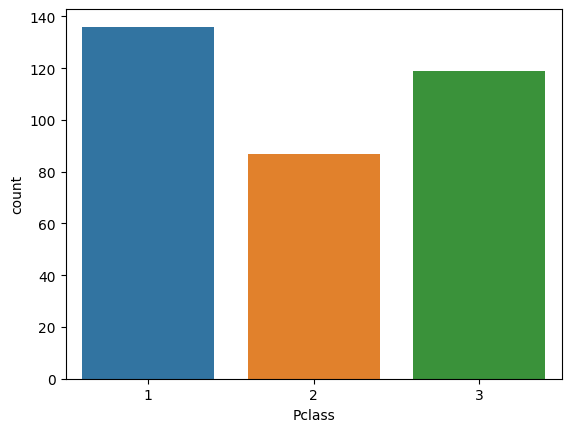

In [234]:
survived_pclass = train.filter(pl.col("Survived") == 1).groupby(pl.col("Pclass")).count().sort(pl.col("Pclass"))

sns.barplot(x="Pclass", y="count", data=survived_pclass.to_pandas())

# Prepare

## One hot encode features

Requires converting to Pandas & back to Polar

In [235]:
features_to_encode = ["Sex", "Pclass"]

In [236]:
df = train.to_pandas()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [246]:
df_encoded = pd.get_dummies(df, columns=features_to_encode)
df_encoded.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,None,S,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,True,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,None,S,True,False,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,True,False,True,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,None,S,False,True,False,False,True


In [238]:
train_encoded = pl.from_pandas(df_encoded)
train_encoded.head()

PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
i64,i64,str,f64,i64,i64,str,f64,str,str,bool,bool,bool,bool,bool
1,0,"""Braund, Mr. Ow…",22.0,1,0,"""A/5 21171""",7.25,null,"""S""",false,true,false,false,true
2,1,"""Cumings, Mrs. …",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C""",true,false,true,false,false
3,1,"""Heikkinen, Mis…",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S""",true,false,false,false,true
4,1,"""Futrelle, Mrs.…",35.0,1,0,"""113803""",53.1,"""C123""","""S""",true,false,true,false,false
5,0,"""Allen, Mr. Wil…",35.0,0,0,"""373450""",8.05,null,"""S""",false,true,false,false,true


# Train XGBoost

## Features

In [239]:
import polars.selectors as cs
from polars.selectors import selector_column_names

feature_cols = cs.contains([f"{f}_" for f in features_to_encode])
cols = selector_column_names(train_encoded, feature_cols)
cols

('Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3')

In [240]:
X = train_encoded.select(feature_cols).to_numpy()
X.shape

(891, 5)

## Targets

In [241]:
y = train_encoded.select(pl.col("Survived")).to_numpy()
y.shape

(891, 1)

## Create & train XGBoost model

In [242]:
model = xgb.XGBClassifier()

In [243]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Measure accuracy on training set

In [244]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X)
y_pred.shape

(891,)

In [245]:
accuracy = accuracy_score(y, y_pred)
accuracy * 100

78.67564534231201